## 策略组合优化

### 1. 查看所有待优化策略组合

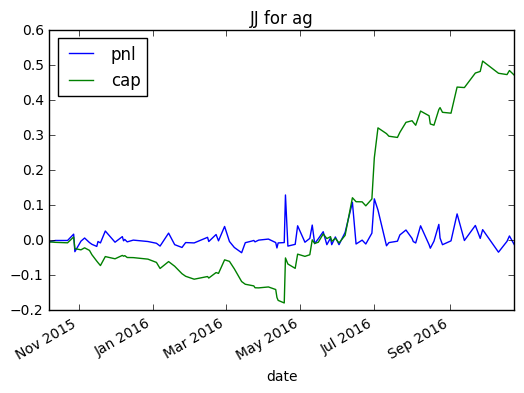

name,JJ for ag
date,
2015-10-08,-0.005348
2015-10-13,-0.006692
2015-10-23,-0.008037
2015-10-28,0.008617
2015-10-29,-0.024731
2015-11-03,-0.028067
2015-11-06,-0.022396
2015-11-10,-0.029722
2015-11-12,-0.042048


In [9]:
# 从数据库获得价差数据
from vtFunction import *
from ctaBase import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
fields = ['name','date','pnl']
strategyNames = ['JJ for ag']
strategyBases = [10000]
plt.close()
startDate = '20151001'
endDate = '20161030'
rtns = pd.DataFrame()
caps = pd.DataFrame()
for name,base in zip(strategyNames,strategyBases):
    datas = loadStrategyData(CAP_DB_NAME,name,startDate,endDate,fields)
    datas['pnl']=datas['pnl']/base
    rtns = pd.concat([rtns,datas],axis = 0)
    datas=datas.set_index('date')
    datas['cap']=datas.apply(np.cumsum)['pnl']
    datas.plot(kind='line',title = name)
    datas.reset_index(drop=False,inplace=True)
    caps = pd.concat([caps,datas],axis = 0)
rtn_table = pd.crosstab(rtns['date'],rtns['name'], values = rtns['pnl'], aggfunc = sum)  #  一维表变为二维表
rtn_table.fillna(0, inplace = True)  #  将NaN置换为0
cap_table = pd.crosstab(caps['date'],caps['name'], values = caps['cap'], aggfunc = sum)  #  一维表变为二维表
cap_table.fillna(method='pad', inplace = True)  #  将NaN置换为0
cap_table.fillna(0, inplace = True)  #  将NaN置换为0
plt.show()
cap_table.head(20)

### 2. 计算协方差矩阵

In [2]:
print rtn_table.mean() * 250
print rtn_table.std() * np.sqrt(250)
rtn_table.corr()

NameError: name 'rtn_table' is not defined

### 3. 计算风险收益曲线

In [2]:
from cvxopt import matrix, solvers

portfolio1 = [0,1,2,3,4,5]
cov_mat = rtn_table.cov() * 250   # 协方差矩阵
exp_rtn = rtn_table.mean() * 250   # 标的预期收益

def cal_efficient_frontier(portfolio): 
    #简单的容错处理
    if len(portfolio) <= 2 or len(portfolio) > 7:
        raise Exception('portfolio必须为长度大于2小于7的list！') 
    # 数据准备
    cov_mat1 = cov_mat.iloc[portfolio][portfolio]
    exp_rtn1 = exp_rtn.iloc[portfolio]
    max_rtn = max(exp_rtn1)
    min_rtn = min(exp_rtn1)
    risks = [] 
    returns = []
    # 均匀选取20个点来作图
    for level_rtn in np.linspace(min_rtn, max_rtn, 20):   
        sec_num = len(portfolio)
        P = 2*matrix(cov_mat1.values)
        q = matrix(np.zeros(sec_num))
        G = matrix(np.diag(-1 * np.ones(sec_num)))
        h = matrix(0.0, (sec_num,1))
        A = matrix(np.matrix([np.ones(sec_num),exp_rtn1.values]))
        b = matrix([1.0,level_rtn])
        solvers.options['show_progress'] = False
        sol = solvers.qp(P,q, G, h, A, b)
        risks.append(sol['primal objective'])
        returns.append(level_rtn)
    return np.sqrt(risks), returns

#  计算画图数据
risk1, return1 = cal_efficient_frontier(portfolio1)
plt.close()
fig = plt.figure(figsize = (14,8))
ax1 = fig.add_subplot(111)
ax1.plot(risk1,return1)
ax1.set_title('Efficient  Frontier', fontsize = 14)
ax1.set_xlabel('Standard  Deviation', fontsize = 12)
ax1.set_ylabel('Expected  Return', fontsize = 12)
ax1.tick_params(labelsize = 12)
ax1.legend(['portfolio1'], loc = 'best', fontsize = 14)
plt.show()

NameError: name 'rtn_table' is not defined

### 4.给定风险厌恶系数，确定每个策略的资金分配

In [3]:
risk_aversion = 90
P = risk_aversion * matrix(cov_mat.values)
q = -1 * matrix(exp_rtn.values)
G = matrix(np.vstack((np.diag(np.ones(len(exp_rtn))),np.diag(-np.ones(len(exp_rtn))))))
h = matrix(np.array([np.ones(len(exp_rtn)),np.zeros(len(exp_rtn))]).reshape(len(exp_rtn)*2,1))
A = matrix(np.ones(len(exp_rtn)),(1,len(exp_rtn)))
b = matrix([1.0])
solvers.options['show_progress'] = False
sol = solvers.qp(P,q, G, h, A, b)
weis=pd.DataFrame(index=exp_rtn.index,data = np.round(sol['x'],2), columns = ['weight'])  # 权重精确到小数点后两位
weis

NameError: name 'matrix' is not defined

### 5.策略组合的资金曲线

In [4]:
plt.close()
cap_table['zh']=1+cap_table['name1']*0.28+cap_table['name2']*0.37+cap_table['name3']*0.07+cap_table['name4']*0.24+cap_table['name5']*0.04
cap_table['zh'].plot()
cap_array=np.matrix([cap_table['name1'],cap_table['name2'],cap_table['name3'],cap_table['name4'],cap_table['name5']])
wei_array=np.matrix([0.22,0.44,0.14,0.12,0.08])
print cap_array
cap_table['zh']=1+np.matrix.dot(cap_array.T,wei_array.T)
cap_table['zh'].plot()
plt.show()

NameError: name 'cap_table' is not defined